In [2]:
import sys
import numpy as np
np.random.seed(42)
import random
random.seed(42)

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import string
from string import punctuation

import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryanli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ryanli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ryanli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ryanli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data Preprocessing (Q2, Q3)

In [3]:
from sklearn.datasets import fetch_20newsgroups
categories=['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

train_dataset = fetch_20newsgroups(subset = 'train',
                                   categories = categories,
                                   shuffle = True,
                                   random_state = None)
test_dataset = fetch_20newsgroups(subset = 'test',
                                 categories = categories,
                                 shuffle = True,
                                 random_state = None)

# stop words
stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

#Build CountVectorizer analyzer
analyzer = CountVectorizer(min_df=3, stop_words=combined_stopwords).build_analyzer()
vectorize = CountVectorizer(min_df=3, stop_words=combined_stopwords)

In [4]:
#check if term is a number
def number_term(t):
    try:
        float(t)
        return True
    except ValueError:
        return False
    
#morphing penn treebank tags to WordNet
def penn_to_wordnet(ptag):
    tags = {'JJ':'a',
           'NN':'n',
           'VB':'v',
           'RB':'r'}
    try:
        return tags[ptag[:2]]
    except:
        return 'n'
    
#lemmatize single document
def lemfxn(doc):
    wnlem = nltk.wordnet.WordNetLemmatizer()
    lemmatize = []
    for word, tag in pos_tag(nltk.word_tokenize(doc)):
        if(not number_term(word)):  #removing number terms
#            if(word not in string.punctuation):  #removing puctuations
            lemmword = wnlem.lemmatize(word.lower(), pos=penn_to_wordnet(tag))
            if (lemmword.isalpha()): lemmatize.append(lemmword) 
    lem_output= ' '.join(lemmatize)
    return lem_output

#lemmatize set of docs
def lemmdata(doc):
    lemlist=[]
    for d in doc:
        lemdoc=lemfxn(d)  #lemm function
        lemlist.append(lemdoc)  #build lemmatized doc list
    return lemlist

In [5]:
#vectorize lemmatized documents
lemvectrain=vectorize.fit_transform(lemmdata(train_dataset.data))
lemvectest=vectorize.transform(lemmdata(test_dataset.data))

#applying the tf-idf transformer to both datasets
tfidf_transformer = TfidfTransformer()

train_tfidf = tfidf_transformer.fit_transform(lemvectrain)
test_tfidf = tfidf_transformer.transform(lemvectest)

In [7]:
#LSI
svd = TruncatedSVD(n_components=50, random_state=42)
X_train_LSI = svd.fit_transform(train_tfidf)
X_test_LSI = svd.transform(test_tfidf)
U,S,Vt = randomized_svd(train_tfidf, n_components=50, random_state = 42) #left/right singular matrices & singular values
SIG = np.diag(S)
lsi_opt = np.sum(np.array(train_tfidf - U.dot(SIG).dot(Vt))**2)  #||X-U_k*SIG_k*V^T_k||^2_F

# Our final targets are in 2 categories: "Computer Technology" and "Recreational Activity"
# Convert 8 imported categories into 2 categories
y_train = [int(i/4) for i in train_dataset.target] 
y_test = [int(i/4) for i in test_dataset.target] 

# Question 6: Gaussian Naive Bayes

In [10]:
def print_classifier_metrics(y_test,y_pred,name="",average='binary'):
    print("Accuracy score for %s: %f" %(name,accuracy_score(y_test,y_pred)))
    print("Recall score for %s: %f" % (name,recall_score(y_test,y_pred,average=average)))
    print("Precision score for %s: %f" % (name,precision_score(y_test,y_pred,average=average)))
    print("F-1 score for %s: %f" % (name,f1_score(y_test,y_pred,average=average)))

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

In [11]:
GNB = GaussianNB()
y_pred_GNB = GNB.fit(X_train_LSI, y_train).predict(X_test_LSI)
print_classifier_metrics(y_test, y_pred_GNB, name="Gaussian Naive Bayes")

Accuracy score for Gaussian Naive Bayes: 0.853016
Recall score for Gaussian Naive Bayes: 0.977358
Precision score for Gaussian Naive Bayes: 0.784452
F-1 score for Gaussian Naive Bayes: 0.870344


Confusion matrix, without normalization
[[1133  427]
 [  36 1554]]
Normalized confusion matrix
[[0.72628205 0.27371795]
 [0.02264151 0.97735849]]


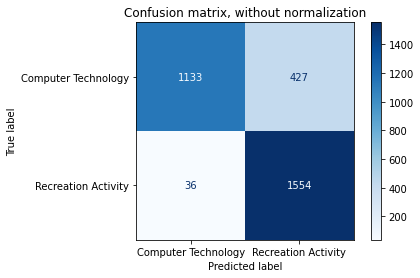

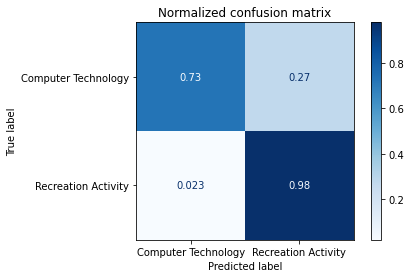

In [12]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['Computer Technology', 'Recreation Activity']
classifier = GNB
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test_LSI, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

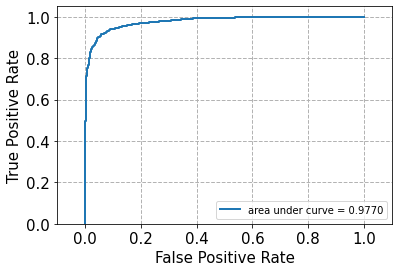

In [14]:
y_score = GNB.predict_proba(X_test_LSI)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
plot_roc(fpr, tpr)